### Faster counting using sorting
This notebook demonstrates how sorting can be used to improve access locality. Here we use sorting in the context of a single CPU computation. The lessons are even more important in the context of a multi-CPU cluster, as will be shown in a separate notebook.

This notebook can be run without spark, using just Jupyter.

#### The task

We are given a text file, here we are using Moby Dick by Herman Melville which can be downloaded from [here](http://faculty.washington.edu/stepp/courses/2004autumn/tcss143/lectures/files/2004-11-08/mobydick.txt).

Our task is to read the file, separate it into words, make all words lower-case, and count the number of occurances of each word.

In [2]:
# initialization for grading
import sys
import os 
testPath = '/'.join(os.getcwd().split('/')[:-1]) + "/Tester"
sys.path.insert(0, testPath )

pickleFile = testPath+ "/SimpleCount.pkl"

In [3]:
from string import lower,strip
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Reading in the file
We read in the file, split it into words and create a list called `all` which contains all of the words in the document

In [ ]:
%%time
import urllib
data_dir='../../Data'
filename='Moby-Dick.txt'

f = urllib.urlretrieve("https://mas-dse-open.s3.amazonaws.com/"+filename, data_dir+'/'+filename)

# Check that the text file is where we expect it to be
!ls -l $data_dir/$filename

In [ ]:
#%%time
file=open(data_dir+'/'+filename,'r')

all=[]
for line in file.readlines():
    line=lower(strip(line))
    if len(line)==0:
        continue
    words=[w for w in re.split(r'\W+',line) if len(w)>0]
    #print line, words
    all+=words
print 'the book contains',len(all),'words'

### Counting  words
First, lets try counting words using the most straight-forward approach.
We create a dictionary `D` and then go through the list of words `all`. For each word we increment the corresponding entry in `D` if the word exists as a key in the dictionary, if it is not in the dictionary, we add it to the dictionary

In [ ]:
%%time
def simple_count(list):
    D={}
    for w in list:
        if w in D.keys():
            D[w]+=1
        else:
            D[w]=1
    return D
D=simple_count(all)

While this takes a long time, it is **not** because of memory locality. Rather, it is simply because using `D.keys()` creates a long list before checking if `w` is in the list This can be easily fixed by replacing `D.keys()` by `D`.

In [ ]:
%%time
def simple_count(list):
    D={}
    for w in list:
        if w in D:
            D[w]+=1
        else:
            D[w]=1
    return D
D=simple_count(all)

#### List the 10 most common words

In [ ]:
S=sorted(D.items(),key=lambda d:d[1],reverse=True)
S[:10]

### Sorted count
Next we show a different way to count. Sort the words alphabetically. Then, when we iterate through the sorted list, all of the occurances of any word appear consecutively, allowing us to quickly count them using just one counter. This counter is added to the dictionary when this element of the list is different than the previous one.

In [ ]:
%%time
def sort_count(list):
    S=sorted(list)
    D={}
    current=''
    count=0
    for w in S:
        if current==w:
            count+=1
        else:
            if current!='':
                D[current]=count
            count=1
            current=w
    return D
D=sort_count(all)

### The effect of memory layout

[numpy arrays](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html#numpy-array) are, by default, organized in a row-major order.


We now run the three counting methods: `simple`, `sort` and `counter` on lists of different length and then plot the performances on a log-log scale.

Why do we use log-log graphs?
1. Because it makes visible the performance across several orders of magnitude.
2. Because if the relationship between the list length $n$ and the run time $t$ is of the form $t=n^\alpha$ then the relationship between $t$ and $n$ on the log-log scale appears linear, with a slope of $\alpha$.

In [28]:
n=1000
a=np.ones([n,n])

In [29]:
%%time
s=0;
for i in range(n):
    s+=a[:,i]

CPU times: user 11.9 ms, sys: 1.18 ms, total: 13.1 ms
Wall time: 11.8 ms


In [30]:
%%time
s=0;
for i in range(n):
    s+=a[i,:]

CPU times: user 2.58 ms, sys: 1.04 ms, total: 3.62 ms
Wall time: 2.61 ms


In [46]:
from time import time
times=[]
for e in arange(1,4.51,0.2):
    n=int(10**e)
    a=np.ones([n,n])
    t0=time()
    s=0;
    for i in range(n):
        s+=a[:,i]
    t1=time()
    s=0;
    for i in range(n):
        s+=a[i,:]
    t2=time()
    times.append({'n':n,'row minor':t1-t0,'row major':t2-t1})
    print n,t2-t1,t1-t0,(t1-t0)/(t2-t1)


10 3.71932983398e-05 0.000115871429443 3.11538461538
15 4.10079956055e-05 9.60826873779e-05 2.34302325581
25 0.000245094299316 0.000143051147461 0.583657587549
39 9.79900360107e-05 0.000207901000977 2.12165450122
63 0.000185012817383 0.000332117080688 1.79510309278
99 0.000257968902588 0.000529050827026 2.05083179298
158 0.000391006469727 0.000741004943848 1.89512195122
251 0.000514030456543 0.00108289718628 2.10667903525
398 0.000589847564697 0.00259399414062 4.39773645918
630 0.000982999801636 0.0080349445343 8.17390249818
999 0.00161790847778 0.0119349956512 7.37680518715
1584 0.0035560131073 0.026046037674 7.32450553134
2511 0.00642609596252 0.0739319324493 11.5049530664
3981 0.0134539604187 0.206027030945 15.3134857345
6309 0.0305621623993 0.470449924469 15.3932146005
9999 0.0772089958191 1.43403196335 18.5733792822
15848 0.206609010696 4.27006697655 20.6673801987
25118 0.526142120361 12.8555328846 24.4335748595


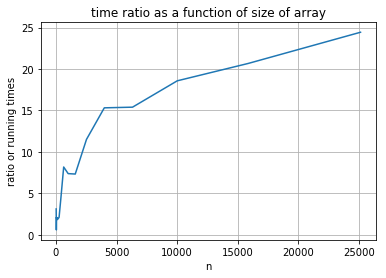

In [50]:
n_list=[a['n'] for a in times]
ratios=[a['row minor']/a['row major'] for a in times]
plot(n_list,ratios)
grid()
xlabel('n')
ylabel('ratio or running times')
title('time ratio as a function of size of array')

### Conclusions
We see from the graph that `sort` and `counter` have very similar run times, and are both better than `simple`. The gap between `sort` and `simple` increases as the length of the list increases. This makes sense because the longer the list, the higher the frequency of cache misses.

We also see that while for `sort` and `counter` the relationship is approximately linear $t \approx n$. The relation for `simple` is of the form $t \approx n^{1.5}$

## Teacher Stuff

In [ ]:
import os
import sys
testPath = '/'.join(os.getcwd().split('/')[:-1]) + "/Tester"
sys.path.insert(0, testPath )
pickleFile = testPath+ "/SimpleCount.pkl"
import SimpleCount_MASTER

In [ ]:
SimpleCount_MASTER.gen_exercise0_1(pickleFile)
SimpleCount_MASTER.gen_exercise0_2(pickleFile)
SimpleCount_MASTER.gen_exercise0_3(pickleFile)
SimpleCount_MASTER.gen_exercise0_4(pickleFile)

In [ ]:
SimpleCount_MASTER.exercise0_1(pickleFile, SimpleCount_MASTER.func_ex0_1)
SimpleCount_MASTER.exercise0_2(pickleFile, SimpleCount_MASTER.func_ex0_2)
SimpleCount_MASTER.exercise0_3(pickleFile, SimpleCount_MASTER.func_ex0_3)
SimpleCount_MASTER.exercise0_4(pickleFile, SimpleCount_MASTER.func_ex0_4)

In [ ]:
SimpleCount.exercise0_1(pickleFile, SimpleCount_MASTER.func_ex0_1)
SimpleCount.exercise0_2(pickleFile, SimpleCount_MASTER.func_ex0_2)
SimpleCount.exercise0_3(pickleFile, SimpleCount_MASTER.func_ex0_3)
SimpleCount.exercise0_4(pickleFile, SimpleCount_MASTER.func_ex0_4)

### End of Teacher Stuff

## Exercise 1 

A `k`-mer is a sequence of `k` consecutive words. 

For example, the `3`-mers in the line `you are my sunshine my only sunshine` are

* `you are my`
* `are my sunshine`
* `my sunshine my`
* `sunshine my only`
* `my only sunsine`

For the sake of simplicity we consider only the `k`-mers that appear in a single line. In other words, we ignore `k`-mers that span more than one line.

Write a function **compute_kmers**, to return the list of `k`-mers in a given text for a given `k`.

######  <span style="color:blue">Code:</span>
```python
text = ['you are my sunshine my only sunshine']
compute_kmers(text,3)
```
######  <span style="color:magenta">Output:</span>
['you are my', 'are my sunshine', 'my sunshine my', 'sunshine my only', 'my only sunsine']

In [ ]:
def compute_kmers(text,k):
    kmers = []
    # your implementation goes here
    return kmers

In [ ]:
import SimpleCount
SimpleCount.exercise0_1(pickleFile, compute_kmers)

In [ ]:
# %load ../Tester/SimpleCount.py
import pickle

from basic_tester import *

def exercise0_1(pickleFile, func_student):
    checkExerciseFromPickle(pickleFile, func_student,TestList,'ex0_1', multiInputs=True)
    
def exercise0_2(pickleFile, func_student):
    checkExerciseFromPickle(pickleFile, func_student,TestList,'ex0_2')
    
def exercise0_3(pickleFile, func_student):
    checkExerciseFromPickle(pickleFile, func_student,TestList,'ex0_3')
    
def exercise0_4(pickleFile, func_student):
    checkExerciseFromPickle(pickleFile, func_student,TestList,'ex0_4', multiInputs=True)


## Exercise 2

Given a list of k-mers, write a function **count_kmers**, to return the dictionary with key as `k`-mer and value as the number of times it has occurred (the count) in the input list.

######  <span style="color:blue">Code:</span>
```python
kmers = ['you are my', 'are my sunshine', 'my sunshine my', 'sunshine my only', 'my only sunshine']
count_kmers(kmers)
```
######  <span style="color:magenta">Output:</span>

{'you are my' : 1, 'are my sunshine' : 1, 'my sunshine my' : 1, 'sunshine my only' : 1, 'my only sunsine' : 1}

In [ ]:
def count_kmers(kmers):
    kmers_count = dict()
    # your implementation goes here 
    return kmers_count

In [ ]:
import SimpleCount
SimpleCount.exercise0_2(pickleFile, count_kmers)

## Exercise 3 

Given the dictionary of k-mer counts from exercise 2, write a function **sort_counts**, to sort the k-mers in descending order by its count. Return a list of tuples. 

* `Each tuple is of the form (kmer, count).`
* `If two k-mers have same count, then sort them lexicographically.`
    
######  <span style="color:blue">Code:</span>
```python
kmers_counts =  {'you are my' : 1, 'are my sunshine' : 1, 'my sunshine my' : 1, 'sunshine my only' : 1, 'my only sunsine' : 1}
sort_counts(kmers_counts)
```
######  <span style="color:magenta">Output:</span>
[('are my sunshine', 1) , ('my only sunsine' , 1) , ('my sunshine my', 1), ('sunshine my only', 1) , ('you are my', 1)]

In [ ]:
def sort_counts(kmers_counts):
    sorted_counts = []
    # your implementation goes here
    return sorted_counts

In [ ]:
import SimpleCount
SimpleCount.exercise0_3(pickleFile, sort_counts)

## Exercise 4 

Given a list of lines, Write a function, to return the list of tuples containing top `n` k-mers with its count from the given text for a given n, k.


######  <span style="color:blue">Code:</span>
```python
n=2
k=3
text = ['you are my sunshine my only sunsine']
get_top_n_kmers(text,n,k)
```
######  <span style="color:magenta">Output:</span>
    [('are my sunshine', 1) , ('my only sunsine' , 1)]

In [ ]:
def get_top_n_kmers(text,n,k):
    kmers = compute_kmers(text,k)
    kmers_count = count_kmers(kmers)
    sorted_counts = sort_counts(kmers_count)
    #SOLUTION BEGINS
    top_n_kmers = []
    #SOLUTION ENDS
    print 'most common %d-mers\n'%k,'\n'.join(['%d:\t%s'%c for c in top_n_kmers])
    return top_n_kmers

In [ ]:
import SimpleCount
SimpleCount.exercise0_4(pickleFile, get_top_n_kmers)